**Название:** Мобильное приложение по продаже продуктов питания.

**Краткое описание:** Необходимо проанализировать, как ведут себя пользователи мобильного приложения по продаже продуктов питания. В нашем распоряжении логи с событиями пользователей, а также результаты эксперимента.


**Описание исходных данных:** 
- EventName — название события
- DeviceIDHash — уникальный идентификатор пользователя
- EventTimestamp — время события
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

План (декомпозиция) анализа данных:

- Шаг1. Загржаем данные и подготовливаем их к анализу
- Шаг2. Анализ данных
- Шаг3. Изучим результаты эксперимента
- Шаг4. Общий вывод    
         
</div>

## Шаг 1. Загружаем данные и подготавливаем их к анализу

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
import re
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

### Изучим общую информацию

In [2]:
logs=pd.read_csv('/datasets/logs_exp.csv', sep='\t')#загружаем данные
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
logs.isna().sum()#проверяем наличие пропусков

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [5]:
logs.duplicated().sum()# проверяем наличи дубликатов

413

#### Вывод
<br>Дубликаты: 413 строк.
<br>Пропуски: отсутствуют.
<br>Требуется переименовать столбцы к нужному нам названию.
<br>Преобразуем формат столбце с датой и временем.

In [6]:
logs1 = logs.groupby(['DeviceIDHash','ExpId']).size().unstack()
logs1.count()

ExpId
246    2489
247    2520
248    2542
dtype: int64

In [7]:
logs1.notnull().all().sum()

0

### Преобразование данных

In [8]:
#duplicated_logs=logs[logs.duplicated()].head()
#duplicated_logs

In [9]:
logs=logs.rename(columns={'EventName':'event_name', 'DeviceIDHash':'user_id', 
                          'EventTimestamp':'event_time', 'ExpId':'group'}) #переименуем названия столбцов
logs.head()

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [10]:
logs['event_time'] = logs['event_time'].astype('datetime64[s]')
logs['date'] = [d.date() for d in logs['event_time']]
logs['time'] = [d.time() for d in logs['event_time']]
logs['date'] = pd.to_datetime(logs.date)
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   date        244126 non-null  datetime64[ns]
 5   time        244126 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


In [11]:
logs=logs.drop_duplicates()#удаляем дубликаты
logs.duplicated().sum()

0

## Шаг 2. Анализ данных

### Ответим на вопросы:
<br> Сколько всего событий в логе?
<br>Сколько всего пользователей в логе?
<br>Сколько в среднем событий приходится на пользователя?
<br>Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
<br>Много ли событий и пользователей вы потеряли, отбросив старые данные?
<br>Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

### Сколько всего событий в логе?

In [12]:
logs.groupby('event_name')['user_id'].count().reset_index()

,event_name,user_id
0,CartScreenAppear,42668
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


#### Вывод
В логе представлены 5 событий: CartScreenAppear, MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, Tutorial

### Сколько всего пользователей в логе?

In [13]:
logs['user_id'].nunique()

7551

#### Вывод
В логе представлено 7551 пользователей

### Сколько в среднем событий приходится на пользователя?

In [14]:
logs.groupby('user_id')['event_name'].count().mean()

32.27559263673685

#### Вывод
В среднем 32 события приходится на пользователя.

### Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [15]:
logs['date'].describe()

count                  243713
unique                     14
top       2019-08-01 00:00:00
freq                    36141
first     2019-07-25 00:00:00
last      2019-08-07 00:00:00
Name: date, dtype: object

Представлены даты в период с 25.07.2019г. - по 07.08.2019г.

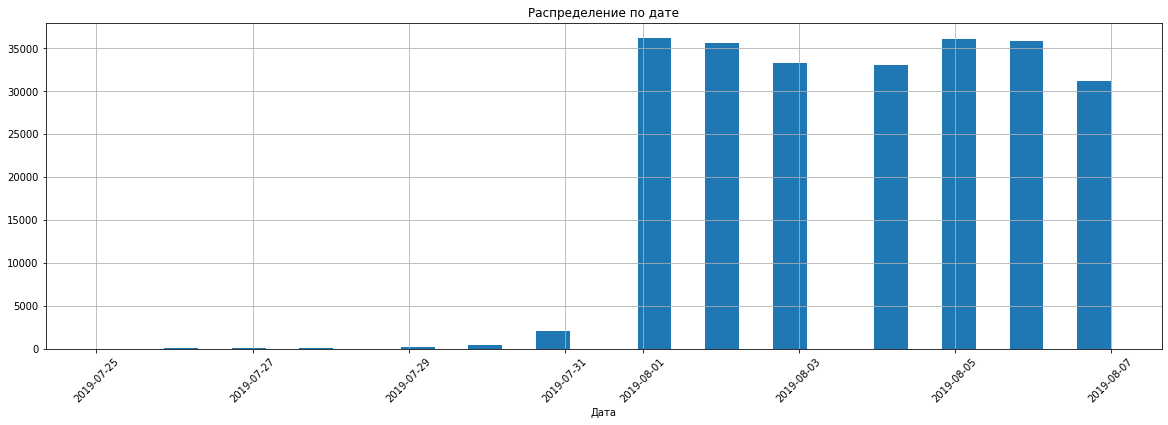

In [16]:
plt.figure(figsize =(20, 6))
logs['date'].hist(bins=30)
plt.title('Распределение по дате')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('')
plt.show()

#### Вывод
В логе с 25.07.2019 по 31.07.2019 наблюдаем не полные данные, значит за этот период отбрасываем данные и берем в расчет перид с 01.08.2019 по 07.08.2019.

In [17]:
logs_before = len(logs)
users_before = logs['user_id'].nunique()
print('Всего событий:', logs_before)
print('Всего пользователей:', users_before)

logs = logs[logs['date'] >= '2019-08-01'].copy()




Всего событий: 243713
Всего пользователей: 7551


In [18]:
# Посмотрим, сколько всего событий и пользователей осталось в логах:
print('Событий после корректировки периода:', len(logs))
print('Пользователей после корректировки периода:', logs['user_id'].nunique())

# Изменения:
print('Изменение количества логов:', len(logs)-logs_before, '({:.1%})'.format((len(logs)-logs_before)/logs_before))
print('Изменение количества пользователей:', logs['user_id'].nunique()-users_before, '({:.1%})'.format((logs['user_id'].nunique()-users_before)/users_before))

Событий после корректировки периода: 240887
Пользователей после корректировки периода: 7534
Изменение количества логов: -2826 (-1.2%)
Изменение количества пользователей: -17 (-0.2%)


#### Вывод
После корректировки событиый, данные уменьшились на 2826(1.2%) лога  и 17(0.2%) пользователей. 

In [19]:
logs_gid = logs.groupby('group')['user_id'].nunique().to_frame()
logs_gid['%'] = logs_gid['user_id'] / logs_gid['user_id'].sum() * 100
logs_gid

,user_id,%
group,,
246,2484,32.970534
247,2513,33.355455
248,2537,33.674011


### Воронка событий

#### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [20]:
# Сгруппируем логи по событиям и посмотрим их количество:
event = logs.groupby('event_name').agg(count = ('user_id', 'count')).sort_values('count', ascending=False).reset_index()
display(event)


,event_name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


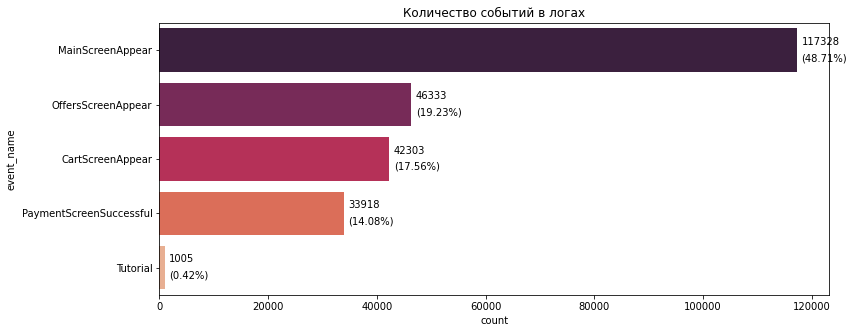

In [21]:
plt.figure(figsize=(12, 5))
plt.title('Количество событий в логах')
sns.barplot(y=event['event_name'], x=event['count'], palette='rocket', orient='h')
for i, q in enumerate(event['count'].values):
    plt.text(q + 800, i - 0.1, str(q), color='black', fontsize = 10)
    plt.text(q + 800, i + 0.2, '({:.2%})'.format(q / event['count'].sum()), color='black', fontsize = 10)
plt.show()

#### Вывод
<br> 1. MainScreenAppear  117328 событий
<br> 2. OffersScreenAppear  46333 события
<br> 3. CartScreenAppear  42303 события
<br> 4. PaymentScreenSuccessful  33918 событий
<br> 5. Tutorial 1005 событий

#### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [22]:
users_event = logs.groupby('event_name').agg(users=('user_id','nunique')).sort_values('users', ascending=False).reset_index()
users_event

,event_name,users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


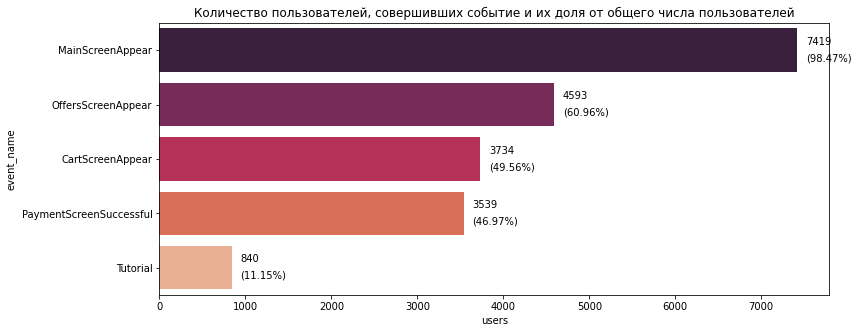

In [23]:
plt.figure(figsize=(12, 5))
plt.title('Количество пользователей, совершивших событие и их доля от общего числа пользователей')
sns.barplot(y=users_event['event_name'], x=users_event['users'], palette='rocket', orient='h')

for i, q in enumerate(users_event['users'].values):
    plt.text(q + 100, i - 0.1, str(q), color='black', fontsize = 10)
    plt.text(q + 100, i + 0.2, '({:.2%})'.format(q / logs['user_id'].nunique()), color='black', fontsize = 10)
plt.show()    

#### Вывод
<br> 1.MainScreenAppear 7419 пользователей (98.47% от общего числа пользователей) совершили действие
<br> 2.OffersScreenAppear 4593 пользователей (60,96% от общего числа пользователей) совершили действие
<br> 3.CartScreenAppear 3734 пользователя (49.56% от общего числа пользователей) совершили действие
<br> 4.PaymentScreenSuccessful 3539 пользователей (46,97% от общего числа пользователей) совершили действие
<br> 5.Tutorial	 840 пользователей (11,15% от общего числа пользователей) совершили действие

#### Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Последовательность цепочки событий выстраивается следующим образом: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful.

Сгруппируем по экспериментальным группам и посмотрим на то, согласуются ли данные разных групп между собой:

In [24]:
event_groups=logs.pivot_table(index=['event_name'], values='user_id', columns='group', aggfunc={'nunique'}).reset_index()
event_groups.columns = ['event_name', '246', '247', '248']
event_groups = event_groups.sort_values(by='248', ascending=False)
event_groups

,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


#### Вывод
Данные разных группы согласуются между собой.

#### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

In [25]:
users_event['share']=users_event['users']/users_event['users'].shift(1)
users_event['share']=(users_event['share']*100).round(2).map('{0:.2f}%'.format)
users_event.sort_values(by='users', ascending=False)

,event_name,users,share
0,MainScreenAppear,7419,nan%
1,OffersScreenAppear,4593,61.91%
2,CartScreenAppear,3734,81.30%
3,PaymentScreenSuccessful,3539,94.78%
4,Tutorial,840,23.74%


#### Вывод
Пользователи, которые проходят на следующий шаг воронки (от числа пользователей предыдущего шага):

61,91% переходят на шаг от MainScreenAppear до OffersScreenAppear
81,3% переходят на шаг от OffersScreenAppear до CartScreenAppear
94,78% переходят на шаг от CartScreenAppear до PaymentScreenSuccessful
23,74% переходят на шаг от PaymentScreenSuccessful до Tutorial

In [36]:
fig = go.Figure(go.Funnel(
    y = ["Главный экран","Предложения/товары", "Корзина", "Оплата"],
    x = users_event['users'],
    textinfo = "value+percent initial"
))
fig.update_layout(title_text='Воронка событий')
fig.show()

#### Вывод 
<br> Больше всего пользователей теряет на после 1ого шага (38.1%), на втором шаге остается 61.9% пользователей.
<br> 47.7% пользователей доходит до конца.

## Шаг3. Изучим результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [27]:
groups = logs.groupby('group').agg(count=('user_id', 'nunique'))
groups

,count
group,
246,2484
247,2513
248,2537


### Статистическая разница между контрольными группами

# При проверке гипотез о равенстве среднего будем применять Z-тест, т.к. будем проводить сравнения двух независимых выборок большого размера. Критический уровень статистической значимости возьмем равным 1%.

<br>**Сформилуруем гипотезы:
<br>H0: статистическая разница между группами отсутствует, т.е. доли пользователей совершивших событие в сравниваемых группах одинаковы.
<br>H1: статистическая разница между группами присутствует, т.е. доли пользователей совершивших событие в сравниваемых группах различны.**


In [28]:
def z_test(successes1, successes2, event, alpha):
    alpha = alpha

    # число пользователей в группе 1 и группе 2:
    n_users = np.array([successes1['user_id'].nunique(), successes2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([successes1[successes1['event_name'] == event]['user_id'].nunique(), successes2[successes2['event_name'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1] 
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('\n'+'\033[1m' + event + ':' + '\033[0m')
    print('p-значение: ', p_value)

    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [29]:
# Составим список всех возможных событий:
events_total = logs['event_name'].unique()
# Зададим критический уровень статистической значимости:
alpha = 0.1/16

<div id='link'></div> 

In [30]:
# Проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:
for event in events_total:
    z_test(logs[logs['group'] == 246], logs[logs['group'] == 247], event, alpha)


Tutorial:
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear:
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Вывод
При заданном уровне значимости нет оснований считать группы 246 и 247 разными.


Для A/A/B-теста пользователей разбили на 3 группы: 2 контрольные(246 и 247) со старыми шрифтами и одну экспериментальную(248) — с новыми.
В 246 группе 2484 пользователей
В 247 группе 2513 пользователей
В 248 группе 2537 пользователей 

In [31]:
# Проверим, есть ли статистически значимая разница между контрольными группами 246 и 248:
for event in events_total:
    z_test(logs[logs['group'] == 246], logs[logs['group'] == 248], event, alpha)


Tutorial:
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear:
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Вывод 
При заданном уровне значимости нет оснований считать группы 246 и 248 разными.

In [32]:
# Проверим, есть ли статистически значимая разница между контрольными группами 247 и 248:
for event in events_total:
    z_test(logs[logs['group'] == 247], logs[logs['group'] == 248], event, alpha)


Tutorial:
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear:
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Вывод
При заданном уровне значимости нет оснований считать группы 247 и 248 разными.

In [33]:
# Проверим есть ли статистически значимая разница между объединённой контрольной и экпериментальной 248 группами:
for event in events_total:
    z_test(pd.concat([logs[logs['group'] == 246], logs[logs['group'] == 247]]), logs[logs['group'] == 248], 
           event, alpha)


Tutorial:
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear:
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Вывод 
При заданном уровне значимости нет оснований считать доли разными, изменение шрифта в приложении на поведение пользователей не повлияло.

## Шаг4. Общий вывод


<br> Для корректного анализа данных мобильного приложения по продаже продуктов питания была проведена предобработка датасета - проверено наличие дубликатов, отсутствующих значений в столбцах, заменены типы данных, изменены названия столбцов.
<br> Проанализировали данные и выявили следующее:
<br>-В логе представлены 5 событий: CartScreenAppear, MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, Tutorial и 7551 пользователей. В среднем 32 события приходится на пользователя. В исследовании участвовали 7534 пользователя и 240887 события.

Воронка пользователей:
<br> 1.MainScreenAppear 7419 пользователей (98.47% от общего числа пользователей) совершили действие
<br> 2.OffersScreenAppear 4593 пользователей (60,96% от общего числа пользователей) совершили действие
<br> 3.CartScreenAppear 3734 пользователя (49.56% от общего числа пользователей) совершили действие
<br> 4.PaymentScreenSuccessful 3539 пользователей (46,97% от общего числа пользователей) совершили действие
<br> 5.Tutorial	 840 пользователей (11,15% от общего числа пользователей) совершили действие
<br> Чаще всего встречается событие с переходом на главный экран.

<br> Больше всего пользователей теряется после первого шага.

<br> При проведенных тестах по каждому из событий, статистически значимой разницы между группами не обнаружено. Изменение шрифта  в приложении на поведение пользователей не повлияло.


